In [64]:
!pip install numpy
!pip install torch

In [66]:
from google.colab import files

uploaded = files.upload()

Saving imitation_state_and_action_data.npz to imitation_state_and_action_data.npz


In [68]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

file_name = list(uploaded.keys())[0]
print(f"Loading file: {file_name}")

data = np.load(file_name)

states = data['state_array']
actions = data['action_array']

print("Data shapes:")
print(f"States shape: {states.shape}")
print(f"Actions shape: {actions.shape}")

print(f"\nDimension check:")
print(f"Number of samples: {len(states)}")
print(f"State vector size: {states.shape[1]} (should be 84)")
print(f"Number of actions: {len(actions)}")

assert states.shape[0] == actions.shape[0], "Mismatch: different number of states and actions"
assert states.shape[1] == 84, "Mismatch: state vector should be 84 dimensions"
print("Data shapes verified successfully!")

Loading file: imitation_state_and_action_data.npz
Data shapes:
States shape: (9085, 84)
Actions shape: (9085,)

Dimension check:
Number of samples: 9085
State vector size: 84 (should be 84)
Number of actions: 9085
Data shapes verified successfully!


In [69]:
unique, counts = np.unique(actions, return_counts=True)

print("Unique:", unique)
print("Counts:", counts)
total_samples = np.sum(counts)
print("total_samples", total_samples)


print("Class Distribution:")
for class_val, count in zip(unique, counts):
    action_name = "No Jump" if class_val == 0 else "Jump"
    percentage = (count / total_samples) * 100
    print(f"{action_name} (class {class_val}): {count:,} samples ({percentage:.1f}%)")

jump_rate = np.mean(actions)
print(f"\nOverall jump rate: {jump_rate:.1%}")



Unique: [0 1]
Counts: [6161 2924]
total_samples 9085
Class Distribution:
No Jump (class 0): 6,161 samples (67.8%)
Jump (class 1): 2,924 samples (32.2%)

Overall jump rate: 32.2%


In [ ]:
# Balance Dataset - Remove excess no-jump samples to create 50/50 split
np.random.seed(42)  # For reproducible results

# Get indices for each class
jump_indices = np.where(actions == 1)[0]
no_jump_indices = np.where(actions == 0)[0]

print(f"Original - Jump: {len(jump_indices)}, No Jump: {len(no_jump_indices)}")

# Sample same number of no-jump as jump samples
n_jump = len(jump_indices)
selected_no_jump = np.random.choice(no_jump_indices, size=n_jump, replace=False)

# Combine all selected indices
balanced_indices = np.concatenate([jump_indices, selected_no_jump])
np.random.shuffle(balanced_indices)

# Create balanced dataset
states = states[balanced_indices]
actions = actions[balanced_indices]

print(f"Balanced - Total: {len(states)} samples")
print(f"New distribution:")
unique_balanced, counts_balanced = np.unique(actions, return_counts=True)
for class_val, count in zip(unique_balanced, counts_balanced):
    action_name = "No Jump" if class_val == 0 else "Jump"
    percentage = (count / len(actions)) * 100
    print(f"{action_name}: {count:,} samples ({percentage:.1f}%)")

In [70]:
from torch.utils.data import TensorDataset, DataLoader, random_split


states_tensor = torch.FloatTensor(states)
actions_tensor = torch.LongTensor(actions)

full_dataset = TensorDataset(states_tensor, actions_tensor)

training_size = int(0.8 * len(full_dataset))
validation_size = len(full_dataset) - training_size

print(f"Train size: {training_size}")
print(f"Val size: {validation_size}")

torch.manual_seed(42)
training, validation = random_split(full_dataset, [training_size, validation_size])

batch_size = 64
train_dataloader = DataLoader(training, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_dataloader)}")
print(f"Val batches: {len(validation_dataloader)}")

def check_distribution_in_loader(dataset, name):
  actions_list = [dataset[i][1].item() for i in range(len(dataset))]
  jump_rate = sum(actions_list)/len(dataset)
  print(f"{name} Jump rate: {jump_rate:.1%}")

check_distribution_in_loader(training, "Train")
check_distribution_in_loader(validation, "Validation")

Train size: 7268
Val size: 1817
Train batches: 114
Val batches: 29
Train Jump rate: 32.0%
Validation Jump rate: 33.0%


In [71]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using device: {device}")
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.neural_network = nn.Sequential(
        nn.Linear(84, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 2),
    )


  def forward(self, x):
    logits = self.neural_network(x)
    return logits

model = NeuralNetwork().to(device)
print(model)


Using device: cuda
NeuralNetwork(
  (neural_network): Sequential(
    (0): Linear(in_features=84, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [72]:
import torch.nn.functional as F
class FocalLoss(nn.Module):
  def __init__(self, alpha=0.75, gamma=2.0, reduction='none'):
    super().__init__()
    self.alpha = alpha
    self.gamma = gamma
  print("starting")
  def forward(self, inputs, targets):
    ce_loss = F.cross_entropy(inputs, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
    return focal_loss.mean()


starting


In [74]:
total_samples = len(actions_tensor)
n_classes = len(unique)
print(counts)
# class_weights = total_samples / (n_classes * torch.tensor(counts, dtype=torch.float))
# class_weights = torch.tensor([0.7, 2.0], dtype=torch.float)
# class_weights = torch.tensor([1.0, 2.0], dtype=torch.float)

# print(f"Class weights: {class_weights}")
# class_weights = class_weights.to(device)


# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = FocalLoss(alpha=0.75, gamma=2.0)

optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# best_val_loss = float('inf')
best_val_accuracy = 0.0
epoch_counter = 0
early_stop_limit = 20

print("Training set up complete")

[6161 2924]
Training set up complete


In [75]:
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting training loop...")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for states, actions in train_dataloader:
        states, actions = states.to(device), actions.to(device)
        optimizer.zero_grad()
        outputs = model(states)
        loss = criterion(outputs, actions)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += actions.size(0)
        train_correct += (predicted == actions).sum().item()

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for states, actions in validation_dataloader:
            states, actions = states.to(device), actions.to(device)
            outputs = model(states)
            loss = criterion(outputs, actions)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += actions.size(0)
            val_correct += (predicted == actions).sum().item()

    # metrics
    avg_train_loss = train_loss / len(train_dataloader)
    avg_val_loss = val_loss / len(validation_dataloader)
    train_accuracy = 100 * train_correct / train_total
    val_accuracy = 100 * val_correct / val_total

    # --- Step the scheduler ---
    scheduler.step(avg_val_loss)

    # plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      epoch_counter = 0
      torch.save(model.state_dict(), 'best_model.pth')
      print(f"✓ Epoch {epoch+1}: New best! Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.1f}%")
    else:
      epoch_counter += 1

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} Acc: {train_accuracy:.1f}% | Val Loss: {avg_val_loss:.4f} Acc: {val_accuracy:.1f}% | Patience: {epoch_counter}/{early_stop_limit}")
    if epoch_counter >= early_stop_limit:
        print("Early stopping triggered.")
        break

print("Training complete!")

Starting training loop...
✓ Epoch 1: New best! Val Loss: 0.1031, Val Acc: 72.3%
Epoch 1/100 | Train Loss: 0.1070 Acc: 71.1% | Val Loss: 0.1031 Acc: 72.3% | Patience: 0/20
✓ Epoch 2: New best! Val Loss: 0.1006, Val Acc: 73.0%
Epoch 2/100 | Train Loss: 0.1001 Acc: 73.7% | Val Loss: 0.1006 Acc: 73.0% | Patience: 0/20
✓ Epoch 3: New best! Val Loss: 0.0986, Val Acc: 73.3%
Epoch 3/100 | Train Loss: 0.0969 Acc: 75.2% | Val Loss: 0.0986 Acc: 73.3% | Patience: 0/20
✓ Epoch 4: New best! Val Loss: 0.0977, Val Acc: 75.3%
Epoch 4/100 | Train Loss: 0.0939 Acc: 76.4% | Val Loss: 0.0977 Acc: 75.3% | Patience: 0/20
Epoch 5/100 | Train Loss: 0.0924 Acc: 76.8% | Val Loss: 0.0947 Acc: 75.0% | Patience: 1/20
✓ Epoch 6: New best! Val Loss: 0.0932, Val Acc: 76.0%
Epoch 6/100 | Train Loss: 0.0898 Acc: 77.6% | Val Loss: 0.0932 Acc: 76.0% | Patience: 0/20
✓ Epoch 7: New best! Val Loss: 0.0910, Val Acc: 76.9%
Epoch 7/100 | Train Loss: 0.0879 Acc: 78.2% | Val Loss: 0.0910 Acc: 76.9% | Patience: 0/20
✓ Epoch 8: Ne

Loaded best model weights from 'best_model.pth'.

Classification Report:
              precision    recall  f1-score   support

     No Jump       0.81      0.95      0.88      1217
        Jump       0.86      0.56      0.68       600

    accuracy                           0.82      1817
   macro avg       0.84      0.76      0.78      1817
weighted avg       0.83      0.82      0.81      1817


Random Sample Predictions:
Sample 1156: Actual: No Jump | Predicted: No Jump ✓
Sample 880: Actual: No Jump | Predicted: No Jump ✓
Sample 1664: Actual: No Jump | Predicted: Jump ✗
Sample 1039: Actual: Jump | Predicted: Jump ✓
Sample 1051: Actual: No Jump | Predicted: No Jump ✓


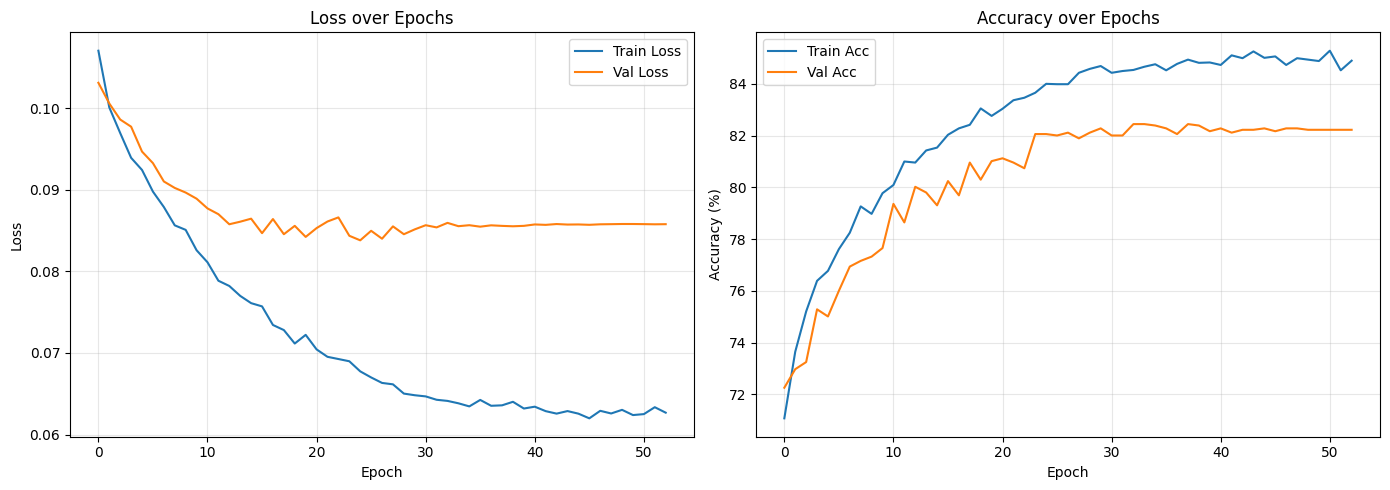

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import random

# --- 1. Load the Best Model ---
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
print("Loaded best model weights from 'best_model.pth'.")

# --- 2. Evaluate on Validation Set ---
all_preds = []
all_labels = []

with torch.no_grad():
    for states, actions in validation_dataloader:
        states, actions = states.to(device), actions.to(device)
        outputs = model(states)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(actions.cpu().numpy())

# --- 3. Classificfation Report ---
# Precision, Recall, F1-Score for each class
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['No Jump', 'Jump']))

# --- 4. Sample Testing ---
print("\nRandom Sample Predictions:")
# 'validation' is the dataset split object from earlier
indices = random.sample(range(len(validation)), 5)

for idx in indices:
    state, actual_action = validation[idx]
    # Add batch dimension: (84) -> (1, 84)
    state_tensor = state.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(state_tensor)
        _, prediction = torch.max(output, 1)

    act_str = "Jump" if actual_action.item() == 1 else "No Jump"
    pred_str = "Jump" if prediction.item() == 1 else "No Jump"
    correct = "✓" if act_str == pred_str else "✗"

    print(f"Sample {idx}: Actual: {act_str} | Predicted: {pred_str} {correct}")

# --- 5. Training Plots ---
plt.figure(figsize=(14, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()